In [1]:
# Imports
import torch
from torch.distributions import Normal,Uniform,Gamma,Laplace,OneHotCategorical,StudentT,HalfNormal,HalfCauchy
import os
import time
from functools import partial

from causal_cocycle.model import cocycle_model,flow_model,cocycle_outcome_model
from causal_cocycle.optimise import *
from causal_cocycle.loss_functions import Loss
from causal_cocycle.conditioners import Empty_Conditioner,Constant_Conditioner,Lin_Conditioner,NN_RELU_Conditioner
from causal_cocycle.transformers import Transformer,Shift_layer,Scale_layer,RQS_layer,Inverse_layer
from causal_cocycle.helper_functions import likelihood_loss,mmd,propensity_score
from causal_cocycle.kernels import *
from causal_cocycle.kde import *

from BD import *

#Shorthand function calls
def NN(i,o=2,width=128,layers=2):
    return NN_RELU_Conditioner(width = width,
                                     layers = layers, 
                                     input_dims =  i, 
                                     output_dims = o,
                                     bias = True)

T = partial(Transformer,logdet = True)

In [2]:
# DGP set up
seed = 0 
N = 5000
D = 10
Zcorr = 0.0
flip_prob = 0.00
coeffs = 1/torch.linspace(1,D,D)[:,None]**1
coeffs *= 1/coeffs.sum()
means = torch.tensor([[-2, 0]]).T # means for mixture U dist
scales = torch.tensor([[-1.0, 1.0]]).T  # variances for mixture U dist
probabilities = torch.tensor([1/2,1/2]) # mixture probs for mixture U dist
base_dists = [HalfNormal(1),HalfCauchy(1)]
noise_dist = Mixture1D(base_dists,probabilities,means,scales)
Zdist1 = Normal(0,1.5)
Zdist2 = Normal(0,1.5)
feature = lambda x,t: (torch.sigmoid(x)<=t.T).float()

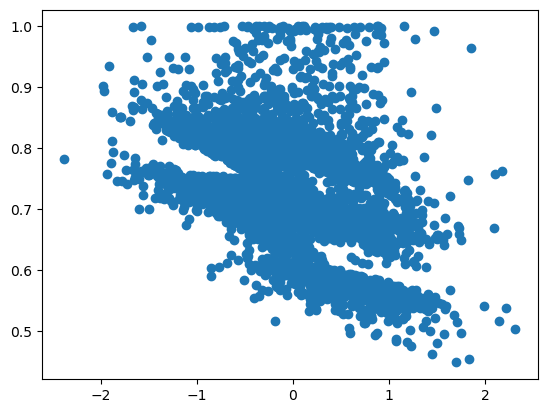

In [3]:
Z1,X1,Y1 = DGP(N,D,partial(policy,flip_prob = flip_prob),coeffs,Zcorr,Zdist1,noise_dist)
plt.scatter(Z1 @ coeffs,torch.sigmoid(Y1));

In [4]:
# Method + opt set up
cocycle_loss = "CMMD_V"
batch_size = 64
validation_method = "CV"
layers = 2
width = 128
train_val_split = 0.5
learn_rate = [1e-3]
scheduler = True
maxiter = 10000
miniter = 10000
weight_decay = 1e-3
RQS_bins = 8

In [5]:
# Setting training optimiser args
opt_args = ["learn_rate",
            "scheduler",
            "batch_size",
            "maxiter",
            "miniter",
            "weight_decay",
            "print_"]
opt_argvals = [learn_rate,
              scheduler,
              batch_size,
             maxiter,
              miniter,
              weight_decay,
              True]

In [6]:
# Specifying models for cross-validation

# Specifying list of hypers to construct models from
hypers = ["weight_decay"]
hypers_list = [[1e-3]]
conditioners_list = [[NN(D+1,1,width,layers)],
                          [NN(D+1,1,width,layers),NN(D+1,1,width,layers)],
                          [NN(D+1,1,width,layers),NN(D+1,1,width,layers),NN(D+1,3*RQS_bins + 2,width,layers)]]
transformers_list = [Transformer([Shift_layer()]),
                           Transformer([Shift_layer(),Scale_layer()]),
                           Transformer([Shift_layer(),Scale_layer(),RQS_layer(RQS_bins)])]

# Constructing all model combinations
models_validation = []
hyper_argvals = []
for m in range(len(conditioners_list)):
    for hyper in hypers_list:
        for hyper_value in hyper:
            models_validation.append(cocycle_model(conditioners_list[m],transformers_list[m]))
            hyper_argvals.append([hyper_value])
hyper_args = [hypers]*len(hyper_argvals)

In [7]:
# DGP
torch.manual_seed(seed)
Z1,X1,Y1 = DGP(N,D,partial(policy,flip_prob = flip_prob),coeffs,Zcorr,Zdist1,noise_dist)
Z2,X2,Y2 = DGP(N,D,partial(policy,flip_prob = flip_prob),coeffs,Zcorr,Zdist2,noise_dist)
Z,X,Y = (torch.row_stack((Z1,Z2)),
         torch.row_stack((X1,X2)),
         torch.row_stack((Y1,Y2)))
id = torch.randperm(Z.size(0))
Z,X,Y = Z[id],X[id],Y[id]

In [8]:
# Getting loss functon and training model
loss_fn =  Loss(loss_fn = cocycle_loss,
                            kernel = [gaussian_kernel(torch.ones(1),1)]*2)
loss_fn.median_heuristic(X1,Y1,subsamples = 10**4)                        
final_models,val_losses = validate(models_validation,
                                         loss_fn,
                                         X,
                                         Y,
                                         [],
                                         validation_method,
                                         train_val_split,
                                         opt_args,
                                         opt_argvals,
                                         hyper_args,
                                         hyper_argvals,
                                         choose_best_model = "per fold")

Training loss last 10 avg is : tensor(-0.6683)
99.9  % completion
Currently optimising model  2 , for fold  1


In [15]:
val_losses

tensor([[-0.4739, -0.4824],
        [-0.4650, -0.4726],
        [-0.4668, -0.4723]])

In [12]:
# Sampling from interventional distribution
torch.manual_seed(seed)
Z1,X1,Y1 = DGP(N,D,partial(policy,flip_prob = flip_prob),coeffs,Zcorr,Zdist1,noise_dist)
Z2,X2,Y2 = DGP(N,D,partial(policy,flip_prob = flip_prob),coeffs,Zcorr,Zdist2,noise_dist)

nintsample = 5000
torch.manual_seed(seed)
Zint1,Xint1,Yint1 = DGP(nintsample,D,partial(new_policy),coeffs,Zcorr,Zdist1,noise_dist)
Zint2,Xint2,Yint2 = DGP(nintsample,D,partial(new_policy),coeffs,Zcorr,Zdist2,noise_dist)

In [13]:
# Drawing counterfactual outcomes
Yint1pred = final_models[1].cocycle(Xint1,X1,Y1).detach()
Yint2pred = final_models[0].cocycle(Xint2,X2,Y2).detach()

tensor(0.1306)


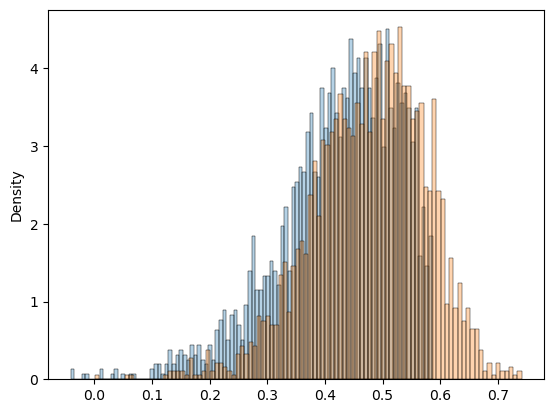

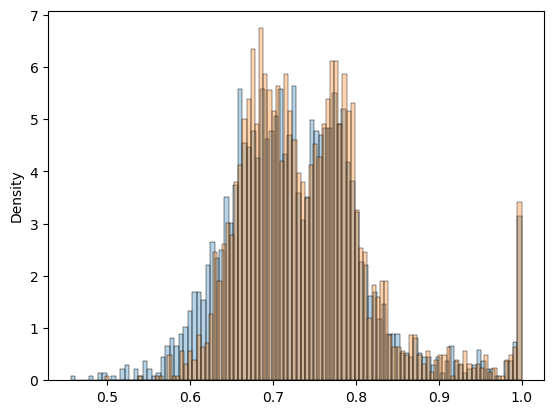

In [14]:
import seaborn as sns
counterfactual_diffs = torch.concatenate(((((Yint2[X2[:,0]==2])-(Y2[X2[:,0]==2]))[:,0]),
                                         (((Yint1[X1[:,0]==2])-(Y1[X1[:,0]==2]))[:,0])))
counterfactual_diffpreds = torch.concatenate(((((Yint2pred[X2[:,0]==2])-(Y2[X2[:,0]==2]))[:,0]),
                                         (((Yint1pred[X1[:,0]==2])-(Y1[X1[:,0]==2]))[:,0])))

print(((counterfactual_diffs - counterfactual_diffpreds).abs()**2).mean()**0.5)
sns.histplot(counterfactual_diffs, bins=100, alpha=0.33, stat = "density")
sns.histplot(counterfactual_diffpreds, bins=100, alpha=0.33, stat = "density")
plt.show()

int = torch.concatenate((torch.sigmoid(Yint1[X1[:,0]==2])[:,0],
                         torch.sigmoid(Yint2[X2[:,0]==2])[:,0]
                        ))
intpreds = torch.concatenate((torch.sigmoid(Yint1pred[X1[:,0]==2])[:,0],
                         torch.sigmoid(Yint2pred[X2[:,0]==2])[:,0]
                        ))
sns.histplot(int, bins=100, alpha=0.33, stat = "density")
sns.histplot(intpreds, bins=100, alpha=0.33, stat = "density")
plt.show()